## Question 4 - How often do players who make the first check win the game?

The goal of the game is checkmate, of which check is half the objective. From my experiences, checks are also signs of being on the offense, which more often than not is correlated with being in an advantageous position. If this correlation is correct, then making the first check is a sign of catching the early advantage. Thus, I am interested in seeing if the player who makes the first check ends up winning the game more often.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

### Data Preprocessing and Loading

For this question, we will be looking at many different time controls. As such, we will be loading the following variables:
- game_id,
- is_check, a binary value describing if the move makes a check,
- result, the winner of the game,
- move_ply, to keep track of which move the first check was made

For our subquestions, we will also be stratifying on
- player elo,
- time control,
-remaining clock time, and
-board evaluation,
so we also have to load these values in.

These are a lot of variables. However, for both our main and sub questions, we will represent each game by one row of data. Thus, we should instead write a helper function that can be used to compress each chunk of moves into a smaller chunk with one row for each game.

One issue to keep track of is the game might not necessarily end at the given chunk boundaries. For example, if the chunks of data as read in is $10^6$ rows each, if the last game in the first chunk starts on row $999998$ for example, then we will not observe a check at all. As such, for each chunk, we will discard the first and last game id, as the resulting data will still be representative of the total population of games. This is a solution intended to bypass the memory limitations.

In [2]:
# these variables we can change
columns_to_load = ['game_id', 'result', 'is_check', 'move_ply', 'white_elo', 'black_elo', 'type', 'time_control', 'clock', 'num_ply', 'termination']
dtype = {'game_id':str, 'result':str, 'is_check':bool, 'move_ply':int, 'white_elo':int, 'black_elo':int, 'white_player':str, 'type':str, 'time_control':str, 'clock':'Int64', 'num_ply':int, 'termination':str}

# a helper function used to:
# 1. drop the first and last game id in each chunk
# 2. drop the games that were not won by checkmate
# Then, we compress each game to one row by:
# a) finding the first row for each game_id where is_check is true, and storing the move number
# b) determining if white or black made the first check, as a boolean called white_check
# c) storing the winner as a -1, 0, or 1 instead of strings (three cases means we cannot use a boolean)
# d) store the time remaining on the clock
def compress(df):
  # step 1
  df = df[~df['game_id'].isin([df['game_id'].iloc[0], df['game_id'].iloc[-1]])]
  # step 2
  df = df[df['termination'] == 'Normal']
  # steps a and d
  df_checks = df.loc[df['is_check'], ['game_id', 'move_ply', 'clock']].rename(columns={'move_ply':'check_ply'}).groupby('game_id', sort=False).first()
  # compress each game to one row
  df = df.drop(columns=['is_check', 'move_ply', 'termination', 'clock']).drop_duplicates(subset='game_id')
  # merge back into df
  df = pd.merge(df, df_checks, on='game_id', how='left')
  df['check_ply'] = df['check_ply'] + 1 # add 1 to 1-index the ply instead of 0-index
  # if we have NA in the check_ply column, that means checkmate was the first check of the game, so we set these values
  # however, for these games, the clocks still evaluate as NA.
  df['check_ply'] = df['check_ply'].fillna(df['num_ply'])
  # step b (even is white because move_ply is originally 0-indexed, but we added 1)
  df['first_check_by'] = df['check_ply'] % 2 == 1
  df['first_check_by'] = df['first_check_by'].map({True: 'white', False: 'black'})
  df['first_check_by'] = df['first_check_by'].fillna(df['result'])
  # step c
  df['result'] = df['result'].map({'1-0': 'white', '0-1': 'black'}).fillna('draw')
  df.rename(columns={'result': 'winner'}, inplace=True)
  # return
  return df

I've tested the helper function on a few smaller chunks first. It took about 80 seconds to load and compress 3 chunks of size 1e3 rows. It takes about 8 minutes to read 200 chunks of size 1e5 rows, or 20 chunks of size 1e6.

In [13]:
url = "https://csslab.cs.toronto.edu/data/chess/monthly/lichess_db_standard_rated_2019-01.csv.bz2"

max_chunks = 40
chunksize = 1e6
chunk_counter = 0
filtered_chunks = []

start_time = time.time()
for chunk in pd.read_csv(url, compression='bz2', usecols = columns_to_load, chunksize=chunksize, dtype=dtype):
    filtered_chunks.append(compress(chunk))
    chunk_counter += 1

    if chunk_counter >= max_chunks:
        break

df = pd.concat(filtered_chunks, ignore_index=True)
df_original = df.copy() # store a copy in case we want to revert the analysis to this checkpoint at any time

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to read the first {chunk_counter} chunks of size {chunksize:.2e}: {elapsed_time:.2f} seconds")

print(df.shape)
df.head()

Time taken to read the first 40 chunks of size 1.00e+06: 640.04 seconds
(481487, 10)


,game_id,type,winner,white_elo,black_elo,time_control,num_ply,check_ply,clock,first_check_by
0,MVfPHhJJ,Blitz,white,1474,1465,300+0,33,26.0,214,black
1,0p86vQ56,Blitz,white,1467,1448,300+0,47,13.0,280,white
2,BhE80eZk,Bullet,black,2463,2564,60+0,38,38.0,<NA>,black
3,fI1gvk1X,Blitz,black,1004,1019,300+0,38,25.0,228,white
4,y02F9Zen,Blitz,white,1334,1286,180+2,75,16.0,156,black


In [80]:
df = df_original # In case I accidentally replace df, I can restore it without loading in all the data again

We are going to be making heatmaps as visualizations because our two variables are who makes the first check and who wins. These variables have 2 and 3 possible outcomes, respectively, so the heatmap will be a $2 \times 3$ grid. As such, let's make a function that we can call to create a heatmap.

In [81]:
def heatmap(df, title, ax=None):
  # assuming we want to use all the data in the dataframe df, which has a winner and first_check_by column.
  joint_distribution = pd.crosstab(df['winner'], df['first_check_by'])

  opp = ((df['winner'] == 'black') & (df['first_check_by'] == 'white')) | \
              ((df['winner'] == 'white') & (df['first_check_by'] == 'black'))
  same = len(df[df['winner'] == df['first_check_by']])
  total = len(df)
  perc_opp = (opp.sum() / total) * 100
  perc_same = (same / total) * 100

  if (ax == None): # No subplots
    # Plot the heatmap
    plt.figure(figsize=(6,4))
    sns.heatmap(joint_distribution, annot=True, cmap="Blues", fmt="d")
    plt.xlabel("First Check Made by")
    plt.ylabel("Winner")
    plt.title(f"""{title}: {total}
    Percentage Same: {perc_same:.2f}%
    Percentage Opposing: {perc_opp:.2f}%""")
    plt.show()

  else: # Subplots
    sns.heatmap(joint_distribution, annot=True, cmap="Blues", fmt="d", ax=ax, vmin=0)
    ax.set_xlabel("First Check Made by")
    ax.set_ylabel("Winner")
    ax.set_title(f"""{title}: {total}
    Percentage Same: {perc_same:.2f}%
    Percentage Opposing: {perc_opp:.2f}%""")

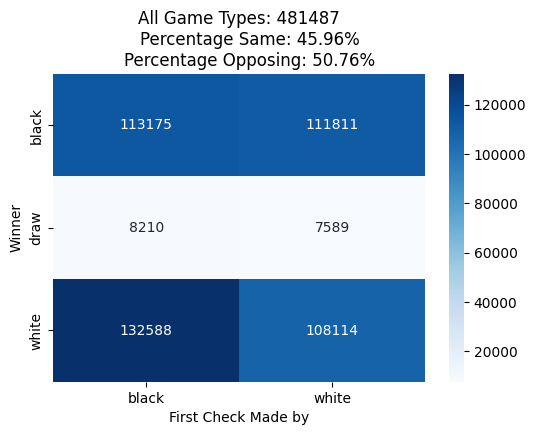

In [82]:
# Call the function we just defined
heatmap(df, "All Game Types")

This result is surprising! I would expect either that the winner is independent of whoever makes the first check or that the person who makes the first check wins more often than not, but in fact, neither of these are true. The person who makes the first check more often than not loses.

One concern we might have is that the first check is actually checkmate. In these games, the winner must be the person who plays the first check. We are interested in seeing how large a slice of the dataset this subset makes up.

### Question 4.1 - How often is the first check also linked with the end of the game?

In [83]:
checkmates = (df['num_ply'] == df['check_ply']).sum()
total = len(df)
prop = checkmates / total

print(f"Percentage of Games where the First Check is Checkmate: {(100 * prop):.2f}%")

Percentage of Games where the First Check is Checkmate: 12.28%


This is actually pretty significant! If we remove these games, what does the resulting heatmap look like?

First, store the original preprocessed dataframe, in case we want to use it again in the future as a checkpoint.

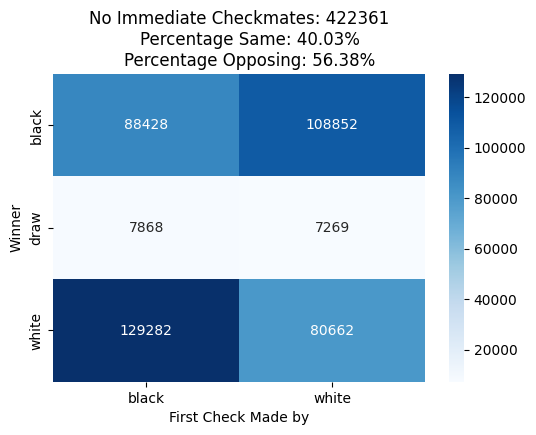

In [84]:
df_nomate = df.loc[df['num_ply'] != df['check_ply'], :]

heatmap(df_nomate, "No Immediate Checkmates")

The disparity becomes even larger. This is not surprising because every game that got removed was a game that fell under the "Same" category, since in those games, players who made the first check immediately won. However, now that we removed the games where the check did not immediately cause checkmate, we note that when a player makes a check that does not end the game, over 56% of the time this player loses.

Let's see if this result is consistent if we stratify on some of our other variables.

### Question 4.2.1 - Is the result consistent upon stratification on time control?

In [85]:
unique_types = df['type'].unique()
print(unique_types)
print(f"There are {len(unique_types)} types.")

['Blitz' 'Bullet' 'Rapid' 'Classical' 'UltraBullet' 'Correspondence']
There are 6 types.


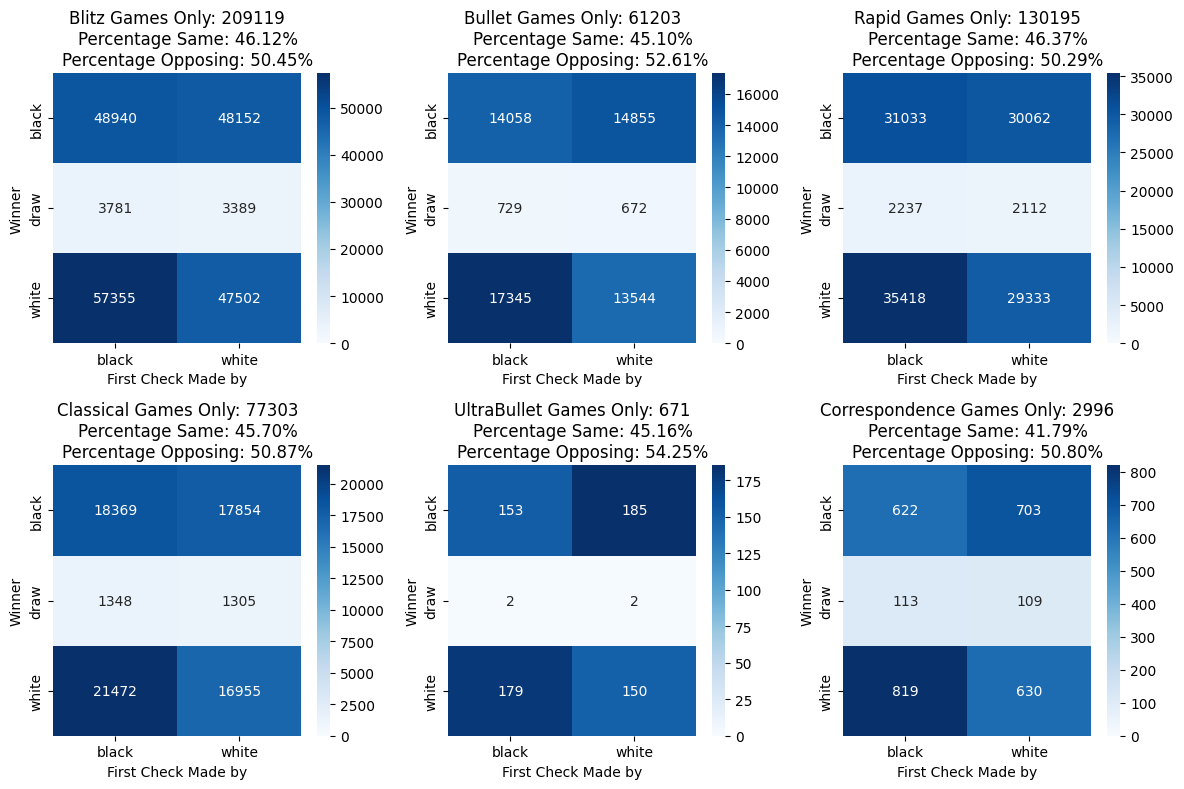

In [86]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, type_value in enumerate(unique_types):
  df_sub = df[df['type'] == type_value]
  heatmap(df_sub, f"{type_value} Games Only", axes[i])

plt.tight_layout()
plt.show()

Some interesting results:
- Correspondence has the highest draw rate, almost 10%, and has the lowest Same percentage.
- Ultrabullet has the lowest draw rate, and the highest Opposing percentage.
- As the amount of time that the players have increase, the further the Opposing percentage decreases, which decreases asymptotically to 50%.

### Question 4.2.2 - Is the result consistent upon stratification on player elo?

For this question, knowing that Lichess lower bounds their elo at 800 during 2019, I chose to set quartiles at 1200, 1600, and 2000. First, add a column for the average elo between the two players to df.

In [87]:
df['elo'] = (df['white_elo'] + df['black_elo']) / 2
df.head()

,game_id,type,winner,white_elo,black_elo,time_control,num_ply,check_ply,clock,first_check_by,elo
0,MVfPHhJJ,Blitz,white,1474,1465,300+0,33,26.0,214,black,1469.5
1,0p86vQ56,Blitz,white,1467,1448,300+0,47,13.0,280,white,1457.5
2,BhE80eZk,Bullet,black,2463,2564,60+0,38,38.0,<NA>,black,2513.5
3,fI1gvk1X,Blitz,black,1004,1019,300+0,38,25.0,228,white,1011.5
4,y02F9Zen,Blitz,white,1334,1286,180+2,75,16.0,156,black,1310.0


Now, make a column that groups the games by elo quadrant.

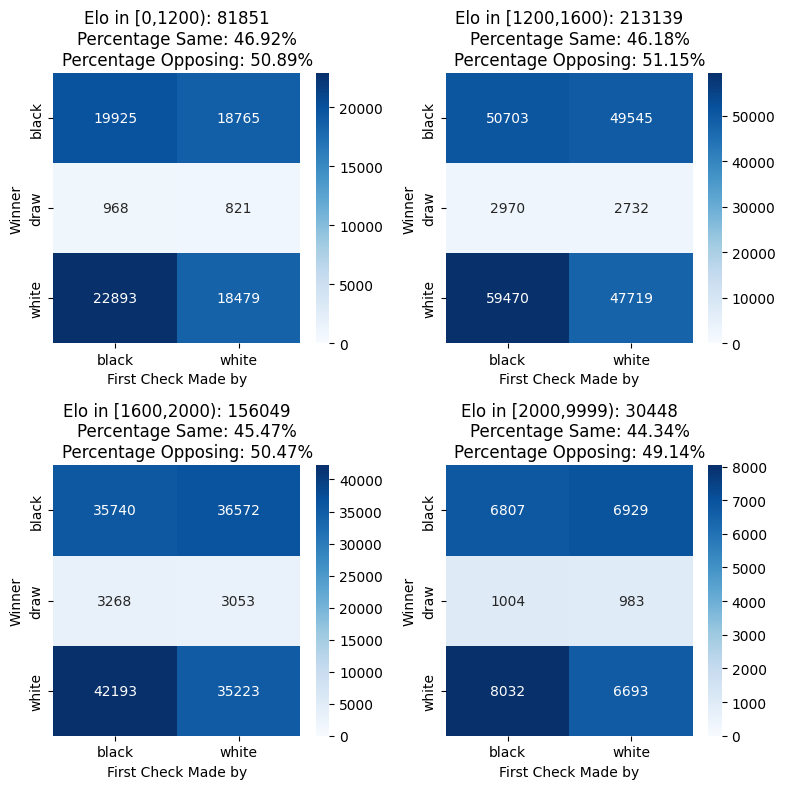

In [88]:
elo_quadrant_bounds = [0, 1200, 1600, 2000, 9999]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

for i in range(len(elo_quadrant_bounds) - 1):
  lower_bound = elo_quadrant_bounds[i]
  upper_bound = elo_quadrant_bounds[i+1]
  df_sub = df[(df['elo'] >= lower_bound) & (df['elo'] < upper_bound)]
  heatmap(df_sub, f"Elo in [{lower_bound},{upper_bound})", axes[i])

plt.tight_layout()
plt.show()

One interesting result is that among all of the heatmaps, the most frequent of the six cells is almost always the cell where Black makes the first check but White ends up winning. Maybe this is caused by something...?

### Question 4.2.3 - What if we stratify on both time control and player elo?

Stratification on two (or more) variables is difficult to visualize. Let's do this by finding the same, opposing, and draw percentages as before, and storing them in a table.

In [89]:
df.columns

Index(['game_id', 'type', 'winner', 'white_elo', 'black_elo', 'time_control',
       'num_ply', 'check_ply', 'clock', 'first_check_by', 'elo'],
      dtype='object')

In [105]:
import itertools

elo_bin_strings = []
# This is to create strings for the elo bins
for i in range(len(elo_quadrant_bounds) - 1):
  lower_bound = elo_quadrant_bounds[i]
  upper_bound = elo_quadrant_bounds[i+1]
  elo_bin_strings.append(f"{lower_bound} to {upper_bound}")

data_list = []

# Now calculate some proportions for each of the strata
for i in range(len(elo_quadrant_bounds) - 1):
  lower_bound = elo_quadrant_bounds[i]
  upper_bound = elo_quadrant_bounds[i+1]
  df_sub = df.loc[(df['elo'] >= lower_bound) & (df['elo'] < upper_bound), ['type', 'winner', 'first_check_by']]
  for type_value in unique_types:
    df_sub_sub = df_sub[df_sub['type'] == type_value]

    opp = len(df_sub_sub[(df_sub_sub['winner'] != 'draw') & (df_sub_sub['winner'] != df_sub_sub['first_check_by'])])
    same = len(df_sub_sub[df_sub_sub['winner'] == df_sub_sub['first_check_by']])
    draw = len(df_sub_sub[df_sub_sub['winner'] == 'draw'])
    total = len(df_sub_sub) # Normalize each combination
    prop_opp = round(100 * opp / total, 3)
    prop_same = round(100 * same / total, 3)
    prop_draw = round(100 * draw / total, 3)

    row_values = {
        'Type': type_value,
        'Player Elo Bin': elo_bin_strings[i],
        'Frequency': total,
        'Same %': prop_same,
        'Opposing %': prop_opp,
        'Draw %': prop_draw
    }
    data_list.append(row_values)

# Now, store the results in a dataframe
df_doublestrata = pd.DataFrame(data_list)

df_doublestrata

,Type,Player Elo Bin,Frequency,Same %,Opposing %,Draw %
0,Blitz,0 to 1200,42697,46.708,50.971,2.321
1,Bullet,0 to 1200,9662,46.429,51.646,1.925
2,Rapid,0 to 1200,18706,47.808,50.091,2.101
3,Classical,0 to 1200,10774,46.668,51.299,2.033
4,UltraBullet,0 to 1200,8,37.500,62.500,0.000
5,Correspondence,0 to 1200,4,25.000,75.000,0.000
6,Blitz,1200 to 1600,87160,46.214,50.886,2.900
7,Bullet,1200 to 1600,25527,45.129,53.054,1.818
8,Rapid,1200 to 1600,60033,46.954,50.364,2.682
9,Classical,1200 to 1600,39002,45.754,51.595,2.651


Let's drop the rows with games fewer than a certain cutoff, and then sort by the opposing percentage, which I think is the most interesting.

None of the strata have a Same Percentage above 50%. The closest is still less than 47%. Meanwhile, almost all of the Opposing Percentages are above 50%.

In [106]:
cutoff = 300
df_doublestrata[df_doublestrata['Frequency'] >= cutoff].sort_values(by='Opposing %', ascending=False).reset_index(drop=True)

,Type,Player Elo Bin,Frequency,Same %,Opposing %,Draw %
0,Correspondence,1200 to 1600,1189,40.959,53.574,5.467
1,Bullet,1600 to 2000,19387,44.690,53.149,2.161
2,UltraBullet,1600 to 2000,322,46.584,53.106,0.311
3,Bullet,1200 to 1600,25527,45.129,53.054,1.818
4,Bullet,0 to 1200,9662,46.429,51.646,1.925
5,Classical,1200 to 1600,39002,45.754,51.595,2.651
6,Classical,0 to 1200,10774,46.668,51.299,2.033
7,Blitz,0 to 1200,42697,46.708,50.971,2.321
8,Blitz,1200 to 1600,87160,46.214,50.886,2.900
9,Bullet,2000 to 9999,6627,44.243,50.747,5.010


This visualization shows some interesting results. There may not seem to be a particular trend, but the last two rows are both the highest elo quadrant, while this quadrant appears nowhere in the first half of the table. (The first row is the exact middle row of the table.) Also, the top 5 rows are all very fast, ie Bullet and Ultrabullet, except for Correspondence.

### Question 4.3.1 - How is the ply number of the first check distributed for a game of a certain game length?

Note: This question was originally "How often is the first check used as a last ditch effort?", which has been moved to Question 7.

Chess engines will play checks if possible to delay an inevitable loss, and human players sometimes do this as well. Thus, maybe the check is actually used in defense. We explore this question more thoroughly in Question 7. Here, we only analyze the distribution of when the first check is made in the game.

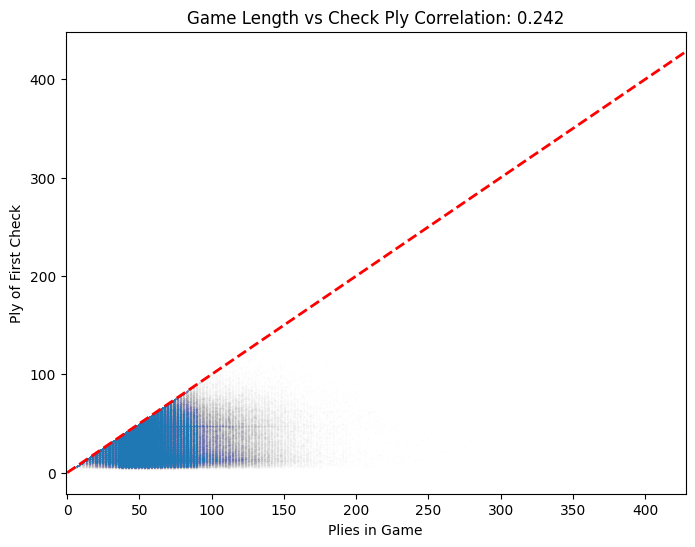

In [56]:
corr = df['num_ply'].corr(df['check_ply'])

max_ply = df['num_ply'].max()

plt.figure(figsize=(8,6))
plt.plot([0,max_ply], [0,max_ply], lw=2, c='red', linestyle='dashed')
plt.scatter(df['num_ply'], df['check_ply'], s=0.5, alpha=0.002)
plt.xlim([-1,max_ply+1])

plt.xlabel("Plies in Game")
plt.ylabel("Ply of First Check")
plt.title(f"Game Length vs Check Ply Correlation: {corr:.3f}")

plt.show()

Let's zoom in on the bottom left.

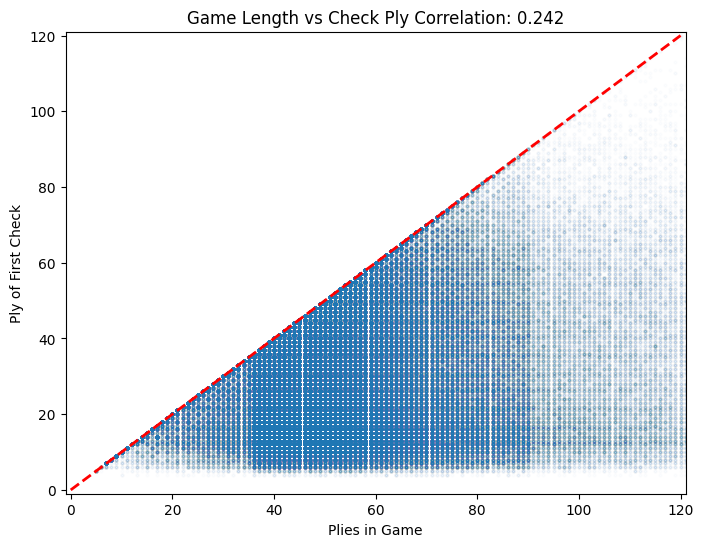

In [57]:
max_ply = 120

plt.figure(figsize=(8,6))
plt.plot([0,max_ply], [0,max_ply], lw=2, c='red', linestyle='dashed')
plt.scatter(df['num_ply'], df['check_ply'], s=4, alpha=0.01)
plt.xlim([-1,max_ply+1])
plt.ylim([-1,max_ply+1])

plt.xlabel("Plies in Game")
plt.ylabel("Ply of First Check")
plt.title(f"Game Length vs Check Ply Correlation: {corr:.3f}")

plt.show()

The red, dashed line is the $45^\circ$ line. Games on this line are games where the first check made resulted immediately in checkmate. We can split the games into three sections.
- For games less than 30 plies, more games are closer to the red line, which indicates that faster games tend to avoid "unwinning" checks, ie checks that are not also checkmate.
- For games between 35 and 70 plies, the distribution looks roughly uniform between 6 and the number of plies.
- For games longer than 70 plies, the distribution tends to skew towards the lower bound.

Now, let's calculate the average ply of the first check for each value of num_ply, and see if this line graph tells us anything more useful.

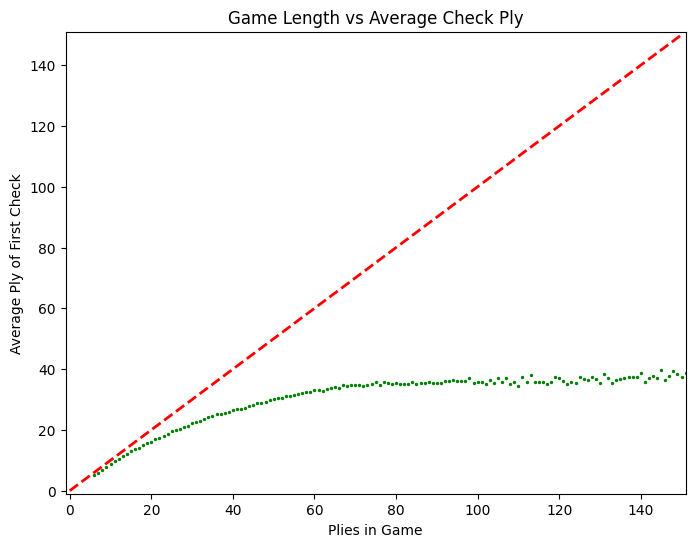

In [63]:
max_ply = 150
cutoff = 30 # we only care about the average if there is a sizable amount of data for a particular ply length. I chose 30 because of the CLT.

check_avg = []

for n_ply in range(max_ply+1):
  df_sub = df[df['num_ply'] == n_ply]['check_ply']
  if (len(df_sub) < cutoff):
    check_avg.append(None)
  else:
    check_avg.append(df_sub.mean())

x = [i+1 for i, value in enumerate(check_avg) if value is not None]
y = [value for value in check_avg if value is not None]

plt.figure(figsize=(8,6))
plt.plot([0,max_ply], [0,max_ply], lw=2, c='red', linestyle='dashed')
plt.scatter(x, y, c='green', s=2)
plt.xlim([-1,max_ply+1])
plt.ylim([-1,max_ply+1])

plt.xlabel("Plies in Game")
plt.ylabel("Average Ply of First Check")
plt.title("Game Length vs Average Check Ply")

plt.show()

The average is not linear, so it does not make sense to calculate and interpret the correlation or linear regression output.

### Question 4.3.2 - How is the game length distributed for a game where the first check is made on a particular ply?

This question is, arguably, more interesting, because during a game, we may observe the ply number of the first check. Now suppose we wish to predict how much longer the game will last.

### Question 4.4 - How often does the player with a lower elo make the first check?

Let's also consider the four cases, where the player with a lower elo makes the first check and wins, and vice versa for each of these binary variables.

### Question 4.5 - How is the number of checks in a game correlated with the number of plies in the game?